The first part of this notebook comrpesses the hourly weather data using a variational autoencoder

In [ ]:
import torch
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import torchvision
from torch.utils.data import Dataset, DataLoader

In [ ]:
def get_data():
    dataframes = []
    dir = "../data/data_hourly_raw_new"
    for file in os.listdir(dir):
        df = pd.read_csv(os.path.join(dir, file),index_col=False)
        df["Zeitstempel"] = pd.to_datetime(df["Zeitstempel"],format="%Y-%m-%dT%H:%M:%S")
        df = df.set_index("Zeitstempel")
        df = df.resample('H').asfreq()
        df["Wert"] = df["Wert"].interpolate(method='time').fillna(method='bfill')
        df["Wert"] = (df["Wert"] - df["Wert"].mean())/df["Wert"].std()
        if(df.index[0] > pd.to_datetime("1981-01-01") or df.index[-1] < pd.to_datetime("2017-01-01")):
            continue
        else:
            dataframes.append(df)

    day_data = {}
    for current_date in tqdm(pd.date_range(start=pd.to_datetime("1981-01-01"),end=pd.to_datetime("2017-01-01"))):
        day_data[current_date] = []
        for df in dataframes:
            df_in_time = df.loc[(df.index >= current_date) & (df.index < current_date + pd.Timedelta(days=1))]
            wert = df_in_time["Wert"].ravel()
            if not len(wert) == 24:
                print(df_in_time)
                return
            day_data[current_date].extend(wert)

    return day_data


In [ ]:
# merge all hourly weather data points into a single dataframe. Also interpolate missing values
day_data = get_data()

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self, encoding_dim):
        super(Encoder, self).__init__()

        self._encoding_dim = encoding_dim

        self.f1 = torch.nn.Linear(len(list(day_data.values())[0]),512)
        self.f2 = torch.nn.Linear(512,256)
        self.relu = torch.nn.ReLU()
        self._dense_mu = torch.nn.Linear(256,encoding_dim)
        self._dense_sigma = torch.nn.Linear(256,encoding_dim)

        # Alexander, Van de Kleut (2020) [Source code] https://avandekleut.github.io/vae/
        self._normal_dist = torch.distributions.Normal(0, 1)
        self._normal_dist.loc = self._normal_dist.loc.cuda()
        self._normal_dist.scale = self._normal_dist.scale.cuda()

    def forward(self, x):

        x = self.relu(self.f2(self.relu(self.f1(x))))

        mu = self._dense_mu(x)
        sigma = self._dense_sigma(x)

        return mu, sigma

    def sample(self, mu, sigma):
        return torch.exp(sigma)*self._normal_dist.sample(mu.size()) + mu

class Decoder(torch.nn.Module):
    def __init__(self, encoding_dim):
        super(Decoder, self).__init__()
        self._encoding_dim = encoding_dim

        self.f1 = torch.nn.Linear(encoding_dim,256)
        self.f2 = torch.nn.Linear(256,512)
        self.f3 = torch.nn.Linear(512,len(list(day_data.values())[0]))
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        
        x = self.f3(self.relu(self.f2(self.relu(self.f1(x)))))

        return x
        
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoding_dim):
        super(AutoEncoder, self).__init__()
        self._encoder = Encoder(encoding_dim)
        self._decoder = Decoder(encoding_dim)


class CustomDataset(Dataset):
    def __init__(self, day_data):
        self.day_data = list(day_data.values())

    def __len__(self):
        return len(self.day_data)
    
    def __getitem__(self, idx):
        return torch.tensor(self.day_data[idx]).to(torch.float32)
    

dataset = CustomDataset(day_data)
data_loader = DataLoader(dataset=dataset,batch_size=64,shuffle=True)


In [ ]:
autoencoder = AutoEncoder(16)
autoencoder.to(torch.device("cuda"))

optimizer = torch.optim.Adam(lr = 0.0001, params = autoencoder.parameters())

for epoch in range(500):

    loss_agg = []



    for vector in tqdm(data_loader):

        optimizer.zero_grad()
        
        input = vector.cuda()

        # get mu and sigma from the image
        mu,sigma = autoencoder._encoder(input)

        # get the corresponding embedding from mu and sigma
        encoded = autoencoder._encoder.sample(mu,sigma)
        
        # decode the image
        decoded = autoencoder._decoder(encoded)

        # Alexander, Van de Kleut (2020) [Source code] https://avandekleut.github.io/vae/
        # hwalsuklee (2017) [Source code] https://github.com/hwalsuklee/tensorflow-mnist-VAE/blob/master/vae.py
        loss = ((input - decoded)**2).sum() + 0.5*(mu**2 + sigma**2 - torch.log(sigma**2 + 0.0000001) -1).sum()
        loss = loss/32
    
        loss.backward()
        optimizer.step()

        loss_agg.append(loss)

    print("ended epoch: ", epoch , " with loss: ", torch.tensor(loss_agg).sum()/4000)

    # save the weights for further usage
    torch.save(autoencoder.state_dict(), "./weights_16.pth")

In [ ]:
day_data_encoded = dict()
for key,value in tqdm(day_data.items()):
    input = torch.unsqueeze(torch.tensor(value).to(torch.float32),dim=0).cuda()
    encoded = autoencoder._encoder.sample(*autoencoder._encoder(input))
    day_data_encoded[key] = torch.squeeze(encoded,dim=0).cpu().detach().numpy()

df = pd.DataFrame.from_dict(day_data_encoded, orient='index')
df.to_csv("../data/day_data_encoded_16.csv",index=True)

This was the compressing using the autoencoder. Now use these to predict SECCI

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts.utils.missing_values import fill_missing_values
from darts import TimeSeries
import sys
from darts.models.forecasting.xgboost import XGBModel

from darts.metrics import rmse
df = pd.read_csv('../data/data_for_darts_normalized_by_test.csv', index_col=0, parse_dates= True)


def get_timeseries(df):
    df = df.loc[df.index.weekday < 5]
    series = TimeSeries.from_dataframe(df,freq = 'B') 
    series = fill_missing_values(series)
    return series

best_longer = pd.read_csv("../data/day_data_encoded_16.csv",index_col=0,parse_dates=True)
longer_covs = get_timeseries(best_longer)

<AxesSubplot:xlabel='datum'>

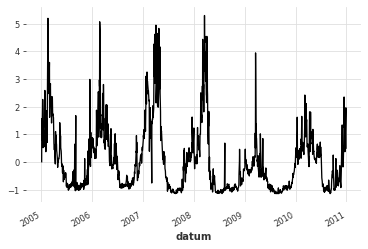

In [3]:
df.NOx.plot()

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
val_df = df.loc[(df.index.year == 2005) | (df.index.year == 2006)].iloc[:,:6]
train_df = df.loc[df.index.year > 2006].iloc[:,:6]

val_x = val_df.iloc[:,:5]
val_y = val_df.NOx
train_x =  train_df.iloc[:,:5]
train_y = train_df.NOx


switcher = GradientBoostingRegressor(random_state=0
)

switcher.fit(train_x,train_y)

vals = switcher.predict(val_x)
np.sqrt(np.mean(np.square(vals - val_y)))

0.12444790141129632

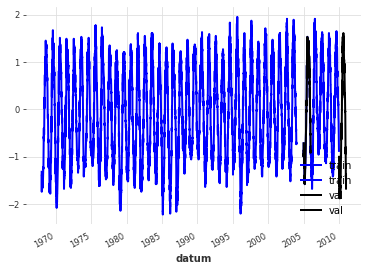

In [5]:
before_train = df.loc[df.index.year < 2004].copy().iloc[3:]

data_df = df.iloc[3:].copy()

data_df.loc[data_df.index.year < 2004,'NOx'] = switcher.predict(data_df.loc[data_df.index.year < 2004].drop(columns = "NOx"))

train1_a = get_timeseries(data_df.loc[ (data_df.index.year <= 2003)])
train1_l = get_timeseries(data_df.loc[(data_df.index.year >= 1990)& (data_df.index.year <= 2003)])
train2 = get_timeseries(data_df.loc[(data_df.index.year > 2004) & (data_df.index.year <= 2009)])

val1 =  get_timeseries(data_df.loc[data_df.index.year == 2005])
val2 =  get_timeseries(data_df.loc[data_df.index.year == 2010])

train1_a['Temperatur'].plot(label = "train",c = "blue")
train2['Temperatur'].plot(label = "train",c = "blue")
val1['Temperatur'].plot(label = "val", c= "black")
val2['Temperatur'].plot(label = "val", c= "black")

In [6]:
catboost_params = {"in_len": 5, "out_len": 3, "lags_lower": 5, "upper_lag": 8, "n_estimators": 134, "max_depth": 4, "learning_rate": 0.13084064565367345, "num_leaves": 173, "l2_leaf_reg": 5.172287143378771, "min_child_samples": 13, "subsample": 0.8560640635268835, "bagging_temperature": 0.32430533153143304}

In [7]:
from darts.models.forecasting.catboost_model import CatBoostModel

def best_catboost(all = False):
    params = catboost_params.copy()
    in_len = int(params.pop('in_len'))
    out_len = int(params.pop("out_len"))


    lags_lower = int(params.pop("lags_lower")) 
    lags_upper = int(params.pop("upper_lag"))

    if not all:

        return CatBoostModel(lags = in_len,
                            lags_future_covariates = (lags_lower,lags_upper),
                            output_chunk_length=out_len, random_state = 0,task_type='GPU', grow_policy = "Depthwise",)
        
    return CatBoostModel(lags = in_len,
                        lags_future_covariates = (lags_lower,lags_upper),
                        output_chunk_length=out_len, random_state = 0,task_type='GPU',  grow_policy = "Lossguide",**params)

In [9]:
from darts.metrics import mse
def train_cols(model,columns,cov,train1):
    model.fit([train1[columns],train2[columns]],future_covariates=[cov,cov])
    
    preds1 = model.predict(550,train1[columns],future_covariates=cov)
    preds2 = model.predict(500,train2[columns],future_covariates=cov)
    
    loss1 = mse(val1[columns],preds1)
    
    loss2 = mse(val2[columns],preds2)
    loss = np.sqrt((loss1 + loss2)/2)
    
    for c in columns:
        l1 = mse(val1[c],preds1[c])
        l2 = mse(val2[c],preds2[c])
        l = np.sqrt((l1 + l2)/ 2)
        
        print(f"{c} - {l}")
    
    return loss, 

In [10]:
best = {("Temperatur","SECCI") : ("Temperatur","SECCI",train1_a)}


def extract_cols(train_columns,extract_column,train1):
    model = best_catboost()
    train_columns = list(train_columns)
    extract_column = list(extract_column)
    
    model.fit([train1[train_columns],train2[train_columns]],future_covariates=[longer_covs,longer_covs])
    
    preds1 = model.predict(600,train1[train_columns],future_covariates=longer_covs).pd_dataframe()
    
    
    preds2 = model.predict(1500,val2[train_columns],future_covariates=longer_covs).pd_dataframe()
    
    df = pd.concat((preds1,preds2))[extract_column]
    if isinstance(df,pd.Series):
        df = df.to_frame()
    return df
    
    

import tqdm

preds = []

for label, t in tqdm.tqdm(best.items()):

    t1 = t[-1]

    preds.append(extract_cols(list(t[:-1]),list(label),t1))


100%|██████████| 1/1 [00:35<00:00, 35.95s/it]


In [16]:
ps = preds.copy()
ps

[component   Temperatur     SECCI
 datum                           
 2003-12-31   -0.776792 -0.915202
 2004-01-01   -0.813432 -0.832475
 2004-01-02   -0.817866 -0.891890
 2004-01-05   -0.805640 -0.508863
 2004-01-06   -0.786070 -0.793163
 ...                ...       ...
 2016-09-23    1.516760  0.761135
 2016-09-26    1.514304  0.550382
 2016-09-27    1.540582  0.700880
 2016-09-28    1.446704 -0.037740
 2016-09-29    1.444133 -0.608685
 
 [2100 rows x 2 columns]]

In [17]:
# read the old submission file to only overwrite SECCI
submission_ds = pd.read_csv('../submissions_student/v10.csv', delimiter=';',skiprows=[1])
submission_ds.index = pd.to_datetime(submission_ds.Datum,format='%d.%m.%Y')

ps = pd.concat(ps,axis = 1)
ps = ps.drop("Temperatur",axis=1)

submission_ds[ps.columns] = ps.loc[submission_ds.index]


import json
with open("../data/means.json") as f:
    means = json.load(f)
    
with open("../data/stds.json") as f:
    stds = np.sqrt(pd.Series(json.load(f)))

for col in ps.columns:
    print(col)
    if col in means:
        
        submission_ds[col] = (submission_ds[col] * stds[col]) + means[col]

SECCI


In [19]:
submission_ds.to_csv('../submissions_student/v14.csv',sep = ';',index= False)
with open("../data/bbdc/bbdc_2023_AWI_data_evaluate_skeleton_student.csv","r") as f:
    metrics = f.read().splitlines()[1]
with open('../submissions_student/v14.csv',"r") as f:
    lines = f.read().splitlines()
lines.insert(1,metrics)


with open('../submissions_student/v14.csv',"w") as f:
    f.write("\n".join(lines))